In [266]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

class Landscape:
    def __init__(self, size, frac_conventional, frac_organic, \
                    mean_soil_health_agri = 1, std_soil_health_agri = 0, mean_biodiversity_agri= 1, std_biodiversity_agri = 0, initial_wealth = 1000, \
                        intensive_production = 1, intensive_costs = 1, soil_health_intensive_impact = 0, biodiversity_intensive_impact = 0., \
                            organic_production = 0.8, organic_costs = 1, soil_health_organic_impact = 0, biodiversity_organic_impact =0, \
                                soil_health_natural_update = +0.001, soil_health_intensive_update = -0.05, soil_health_organic_update = 0.05, \
                                    biodiversity_natural_update = +0.01, biodiversity_intensive_update = -0.1, biodiversity_organic_update = 0.01, biodiversity_max_organic = 0.5, \
                                        cross_price_elasticity = 0.03):
        
        self.size = size

        ### Conventional ###
        self.intensive_production = intensive_production
        self.intensive_costs = intensive_costs
        self.soil_health_intensive_impact = soil_health_intensive_impact
        self.biodiversity_intensive_impact = biodiversity_intensive_impact

        ### Organic ###
        self.organic_production = organic_production
        self.organic_costs = organic_costs
        self.soil_health_organic_impact = soil_health_organic_impact
        self.biodiversity_organic_impact = biodiversity_organic_impact

        ### Soil ###
        self.soil_health_organic_update = soil_health_organic_update
        self.soil_health_intensive_update = soil_health_intensive_update 
        self.soil_health_natural_update = soil_health_natural_update 

        ### Biodiversity ###
        self.biodiversity_organic_update = biodiversity_organic_update
        self.biodiversity_intensive_update = biodiversity_intensive_update
        self.biodiversity_natural_update = biodiversity_natural_update
        self.biodiversity_max_organic = biodiversity_max_organic 

        ### Demand ###
        self.cross_price_elasticity = cross_price_elasticity

        # Initialize matrices
        if frac_conventional + frac_organic > 1:
            raise AttributeError("Input the right amount of initial fractions")
        
        self.initialize_land_types(frac_conventional, frac_organic)
        self.soil_health, self.biodiversity = self.initialize_soil_health_and_biodiversity(mean_soil_health_agri, std_soil_health_agri, mean_biodiversity_agri, std_biodiversity_agri)

        # Calculate initial productivity
        self.productivity = self.productionfunction()
        initial_productivity = np.sum(self.productivity)
        self.demand = initial_productivity
        self.organic_fraction_demand = np.sum(self.productivity[self.land_type == 'O']) / self.demand
        self.costs =  self.computecosts()   
        self.profits = self.computeprofit() 
        self.previous_prime_premium = self.organic_market_price/self.intensive_market_price
        self.wealth = initial_wealth * np.ones((self.size, self.size)) 

        # Initialize data for plotting
        self.data = {'O':[], 'I': [], 'N':[], \
                        'I_prod': [], 'I_demand': [], 'I_price': [], 'I_soil': [], 'I_bio': [], 'I_costs':[], 'I_wealth':[], 'I_profits':[], \
                            'O_prod': [], 'O_demand':[], 'O_price':[], 'O_soil': [], 'O_bio':[], 'O_costs':[], 'O_wealth':[], 'O_profits':[]}
        
        self.aggregate_data()

    def initialize_land_types(self, frac_conventional, frac_organic):
        total_cells = self.size * self.size
        num_conventional = int(total_cells * frac_conventional)
        num_organic = int(total_cells * frac_organic)
        num_natural = total_cells - num_conventional - num_organic

        land_types_flat = (['I'] * num_conventional +
                           ['O'] * num_organic +
                           ['N'] * num_natural)

        np.random.shuffle(land_types_flat)
        self.land_type = np.array(land_types_flat).reshape((self.size, self.size))

    def initialize_soil_health_and_biodiversity(self, soil_mean, soil_std, bio_mean, bio_std):
        soil_health = np.zeros((self.size, self.size))
        soil_health[self.land_type != 'N'] = np.random.normal(soil_mean, soil_std, (self.size, self.size))[self.land_type != 'N']
        soil_health[self.land_type == 'N'] = 1
        soil_health = np.clip(soil_health, 0, 1)
        
        biodiversity = np.zeros((self.size, self.size))
        biodiversity[self.land_type != 'N'] = np.random.normal(bio_mean, bio_std, (self.size, self.size))[self.land_type != 'N']
        biodiversity[self.land_type == 'N'] = 1
        biodiversity = np.clip(biodiversity, 0, 1)

        return soil_health, biodiversity
    
    def update_soil_health(self, omega = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.soil_health, kernel, mode='wrap')

        delta = np.zeros((self.size, self.size))
        delta[self.land_type == 'I'] = self.soil_health_intensive_update
        delta[self.land_type == 'O'] = self.soil_health_organic_update
        delta[self.land_type == 'N'] = self.soil_health_natural_update

        self.soil_health += self.soil_health *( (1 - omega) * delta + omega * avg_neighbors )

        self.soil_health = np.clip(self.soil_health, 0, 1)

    def update_biodiversity(self, omega = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.biodiversity, kernel, mode='wrap')

        delta = np.zeros((self.size, self.size))
        delta[self.land_type == 'I'] = self.biodiversity_intensive_update
        delta[self.land_type == 'O'] = np.sign(self.biodiversity_max_organic - self.biodiversity[self.land_type == 'O']) * self.biodiversity_organic_update
        delta[self.land_type == 'N'] = self.biodiversity_natural_update

        self.biodiversity += self.biodiversity * ( (1 - omega) * delta + omega * avg_neighbors )

        self.biodiversity = np.clip(self.biodiversity, 0, 1)
    
    def productionfunction(self):
        production = np.zeros((self.size, self.size))
        production[self.land_type == 'I'] = self.intensive_production * (1 + np.random.normal(0,0.01, (self.size,self.size))[self.land_type =='I'])
        production[self.land_type == 'O'] = self.organic_production * self.soil_health[self.land_type == 'O']**self.soil_health_organic_impact * self.biodiversity[self.land_type == 'O']**self.biodiversity_organic_impact * (1 + np.random.normal(0,0.01, (self.size,self.size))[self.land_type =='O'])
        return production
    
    def computecosts(self):
        costs = np.zeros((self.size, self.size))
        costs[self.land_type == 'I'] = self.intensive_costs * self.soil_health[self.land_type == 'I']**self.soil_health_intensive_impact * self.biodiversity[self.land_type == 'I']**self.biodiversity_intensive_impact
        costs[self.land_type == 'O'] = self.organic_costs 
        return costs

    def compute_sellingmatrix_price(self, demand, productivity, prices):

        # Flatten and sort the production values along with their indices
        flattened_productivity = productivity.ravel()
        flattened_prices = prices.ravel()
        sorted_indices = np.argsort(flattened_prices)
        sorted_productivity = flattened_productivity[sorted_indices]

        # Calculate sold fractions
        cumulative_production = np.cumsum(sorted_productivity)
        sold_fraction = np.zeros_like(sorted_productivity)

        # Find the index where demand is just met or exceeded
        meet_demand_index = np.argmax(cumulative_production >= demand)

        # If demand is less than or equal to total production
        if cumulative_production[meet_demand_index] >= demand:
            # Units fully sold
            sold_fraction[:meet_demand_index] = 1
            # The last unit might be partially sold
            if meet_demand_index == 0:
                sold_fraction[meet_demand_index] = (demand) / sorted_productivity[meet_demand_index]
            else:
                sold_fraction[meet_demand_index] = (demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
        
            market_price = prices.ravel()[sorted_indices][meet_demand_index]
        
        else:
            # All units are sold
            sold_fraction[:] = 1
            sorted_prices = prices.ravel()[sorted_indices]
            market_price = sorted_prices[sorted_prices > 0][-1]

        # Reconstruct the matrix with the sold fractions in their original positions
        reconstructed_matrix = np.zeros_like(sold_fraction)
        reconstructed_matrix[sorted_indices] = sold_fraction

        return reconstructed_matrix.reshape(self.productivity.shape), market_price
    
    def computeprofit(self):

        self.prices = self.costs / np.where(self.productivity>0, self.productivity, 1)

        profits = np.zeros((self.size, self.size))

        # Intensive
        if np.any(self.land_type == 'I'):
            intensive_prices = self.prices * (self.land_type == 'I')
            intensive_production = self.productivity * (self.land_type == 'I')
            intensive_demand = (1 - self.organic_fraction_demand) * self.demand
            selling_matrix, self.intensive_market_price = self.compute_sellingmatrix_price(intensive_demand, intensive_production, intensive_prices)
            profits += (self.land_type == 'I') * (selling_matrix * self.intensive_market_price * intensive_production - self.costs)
        else:
            self.intensive_market_price = 0

        
        # print('productivity')
        # print(intensive_production)
        # print('Prices')
        # print(self.prices)
        # print('Selling matrix')
        # print(selling_matrix)
        # print('Total Production' ,  np.sum(intensive_production), ' Demand ', intensive_demand)
        # print('Market Price')
        # print(self.intensive_market_price)
        # print('Profit')
        # print(profits)
        # print('--------------------------------')

        # Organic
        if np.any(self.land_type == 'O'):
            organic_prices = self.prices * (self.land_type == 'O')
            organic_production = self.productivity * (self.land_type == 'O')
            organic_demand = self.organic_fraction_demand * self.demand
            selling_matrix, self.organic_market_price = self.compute_sellingmatrix_price(organic_demand, organic_production, organic_prices)
            profits += (self.land_type == 'O') * (selling_matrix * self.organic_market_price * organic_production - self.costs)
        else: 
            self.organic_market_price = 0

        return profits

    def update_organic_fraction_demand(self):
        
        if np.any(self.land_type == 'I'):
            organic_fraction_demand = self.organic_fraction_demand * (1 + self.cross_price_elasticity * (self.previous_prime_premium - self.organic_market_price/self.intensive_market_price))
            self.previous_prime_premium = 0.6 * self.previous_prime_premium + 0.4 * self.organic_market_price / self.intensive_market_price

            # new_price_premium = self.organic_market_price/self.intensive_market_price
            # organic_fraction_demand = self.organic_fraction_demand + self.cross_price_elasticity * (new_price_premium - self.previous_price_premium) / self.previous_price_premium
            # self.previous_price_premium = new_price_premium
        else:
            organic_fraction_demand = self.organic_fraction_demand

        return organic_fraction_demand

    def update_productivity_and_economic_value(self):
        self.organic_fraction_demand = self.update_organic_fraction_demand()
        self.productivity = self.productionfunction()   
        self.costs =  self.computecosts()   
        self.profits = self.computeprofit()
        self.wealth += self.profits

    def farmers_removal(self):
        
        bankrupt = self.wealth < -1
        self.land_type[bankrupt] = 'N'
        self.wealth[bankrupt] = 0

    def farmers_introduction(self):

        available_plots = np.any(self.land_type == 'N')

        ### Intensive
        intensive_demand = (1 - self.organic_fraction_demand) * self.demand
        intensive_production = np.sum(self.productivity[self.land_type == 'I'])
        intensive_delta_demand = intensive_demand - intensive_production
        if intensive_delta_demand > 0:
            intensive_new_farmers = int(np.round(intensive_delta_demand / np.mean(self.productivity[self.land_type == 'I'])))
        else: 
            intensive_new_farmers = int(0)

        ### Organic
        organic_demand = self.organic_fraction_demand * self.demand
        organic_production = np.sum(self.productivity[self.land_type == 'O'])
        organic_delta_demand = organic_demand - organic_production
        if organic_delta_demand > 0:
            organic_new_farmers = int(np.round(organic_delta_demand / np.mean(self.productivity[self.land_type == 'O'])))  
        else:
            organic_new_farmers = int(0)

        ### Plots allocation
        if organic_new_farmers + intensive_new_farmers > 0:
            if organic_new_farmers + intensive_new_farmers > available_plots:
                organic_new_farmers = int(np.round(available_plots * organic_delta_demand / (intensive_delta_demand + organic_delta_demand)))
                intensive_new_farmers = int(np.round(available_plots * intensive_delta_demand / (intensive_delta_demand + organic_delta_demand)))

            candidate_list = np.argwhere(self.land_type == 'N')
            candidate_selected = np.random.choice(np.arange(candidate_list.shape[0]), size= int(organic_new_farmers + intensive_new_farmers), replace=False)
            organic_selected = candidate_selected[:organic_new_farmers]
            intesive_selected = candidate_selected[organic_new_farmers:int(organic_new_farmers+intensive_new_farmers)]

            # intensive
            if intensive_new_farmers > 0:
                candidate_matrix = np.full((self.size, self.size), False, dtype=bool)
                candidate_matrix[candidate_list[intesive_selected][:,0], candidate_list[intesive_selected][:,1]]=True
                self.land_type[candidate_matrix] = 'I'
                self.wealth[candidate_matrix] = np.mean(self.wealth[self.land_type == 'I'])

            # Organic
            if organic_new_farmers > 0:
                candidate_matrix = np.full((self.size, self.size), False, dtype=bool)
                candidate_matrix[candidate_list[organic_selected][:,0], candidate_list[organic_selected][:,1]] = True
                self.land_type[candidate_matrix] = 'O'
                self.wealth[candidate_matrix] = np.mean(self.wealth[self.land_type == 'O'])           
    
    def simulate_year(self):
        self.update_productivity_and_economic_value()
        self.aggregate_data()
        self.farmers_removal()
        self.farmers_introduction()
        self.update_soil_health()
        self.update_biodiversity()
        
    def aggregate_data(self):
        self.data['I'].append(np.sum(self.land_type == 'I')/self.size**2)
        self.data['O'].append(np.sum(self.land_type == 'O')/self.size**2)
        self.data['N'].append(np.sum(self.land_type == 'N')/self.size**2)
        self.data['I_prod'].append(np.sum(self.productivity[self.land_type == 'I']))
        self.data['I_demand'].append((1-self.organic_fraction_demand) * self.demand)
        self.data['I_price'].append(self.intensive_market_price)
        self.data['I_soil'].append(self.soil_health[self.land_type == 'I'].mean())
        self.data['I_bio'].append(self.biodiversity[self.land_type == 'I'].mean())
        self.data['I_costs'].append(self.costs[self.land_type == 'I'].mean())
        self.data['I_wealth'].append(self.wealth[self.land_type == 'I'].mean())
        self.data['I_profits'].append(self.profits[self.land_type == 'I'].mean())
        self.data['O_prod'].append(np.sum(self.productivity[self.land_type == 'O']))
        self.data['O_demand'].append(self.organic_fraction_demand * self.demand)
        self.data['O_price'].append(self.organic_market_price)
        self.data['O_soil'].append(self.soil_health[self.land_type == 'O'].mean())
        self.data['O_bio'].append(self.biodiversity[self.land_type == 'O'].mean())
        self.data['O_costs'].append(self.costs[self.land_type == 'O'].mean())
        self.data['O_wealth'].append(self.wealth[self.land_type == 'O'].mean())
        self.data['O_profits'].append(self.profits[self.land_type == 'O'].mean())

    def plot_spatial_data(self):

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(self.soil_health, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 0].set_title('Soil Health')
        axs[0, 1].imshow(self.biodiversity, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 1].set_title('Biodiversity')
        axs[1, 0].imshow(self.productivity, cmap='YlOrRd', vmin = 0, vmax = 1)
        axs[1, 0].set_title('Productivity')
        axs[1, 1].imshow(self.wealth, cmap='YlOrRd')
        axs[1, 1].set_title('Economic Value')
  
        for axes in axs.reshape(-1):
            for (j,i), label in np.ndenumerate(self.land_type):
                axes.text(i,j,label,ha='center',va='center')
                axes.text(i,j,label,ha='center',va='center')

        plt.show()
    
    def plot_all_data(self):
        
        fig = plt.figure(figsize=(25,15))
        gs = GridSpec(nrows=4, ncols=8)

        ax = fig.add_subplot(gs[0, 1:3])
        ax.plot(self.data['I'], label = 'I', ls='--', c = 'k')
        ax.plot(self.data['O'], label = 'O', ls=':', c = 'k')
        ax.plot(self.data['N'], label = 'N', ls='-', c = 'k')
        ax.set_title('Fraction')
        ax.grid(alpha = 0.3)
        ax.legend()

        ax = fig.add_subplot(gs[0, 3:5])
        ax.plot(np.array(self.data['I_prod']) + np.array(self.data['O_prod']), label = 'Y', ls='-', c='k')
        ax.plot(np.array(self.data['I_demand']) + np.array(self.data['O_demand']), label = 'D', ls='--', c='k')
        ax.set_title('Production')
        ax.grid(alpha = 0.3)
        ax.legend()

        ax = fig.add_subplot(gs[0, 5:7]) 
        ax.plot(np.array(self.data['O_price'])/np.array(self.data['I_price']), c='k')
        ax.set_title('Price Premium')
        ax.grid(alpha = 0.3)

        #### Intensive ####
        color_back = 'moccasin'
        ax = fig.add_subplot(gs[1, :2]) 
        ax.plot(np.array(self.data['I_prod']), label = 'Y', ls='-', c='k')
        ax.plot(np.array(self.data['I_demand']), label = 'D', ls='--', c='k')
        ax.set_title('Production')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)
        ax.legend()    

        ax = fig.add_subplot(gs[1, 2:4])
        ax.plot(np.array(self.data['I_costs']), ls='-', c='k', label = '5th') 
        ax.set_title('Cost')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)


        ax = fig.add_subplot(gs[2, 0:2])

        ax.plot(np.array(self.data['I_soil']), ls='-', c='k', label = '5th') 
        ax.set_title('Soil')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)


        ax = fig.add_subplot(gs[2, 2:4])
        ax.plot(np.array(self.data['I_bio']), ls='-', c='k', label = '5th') 
        ax.set_title('Bio')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)


        #### Organic ####
        color_back = 'thistle'
        ax = fig.add_subplot(gs[1, 4:6]) 
        ax.plot(np.array(self.data['O_prod']), label = 'Y', ls='-', c='k')
        ax.plot(np.array(self.data['O_demand']), label = 'D', ls='--', c='k')
        ax.set_title('Production')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)
        ax.legend()

        ax = fig.add_subplot(gs[1, 6:8])
        ax.plot(np.array(self.data['O_costs']), ls='-', c='k') 
        ax.set_title('Cost')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)
 

        ax = fig.add_subplot(gs[2, 4:6])
        ax.plot(np.array(self.data['O_soil']), ls='-', c='k')
        ax.set_title('Soil')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)
  

        ax = fig.add_subplot(gs[2, 6:8])
        ax.plot(np.array(self.data['O_bio']), ls='-', c='k')
        ax.set_title('Bio')
        ax.grid(alpha = 0.3)
        ax.set_facecolor(color=color_back)
        

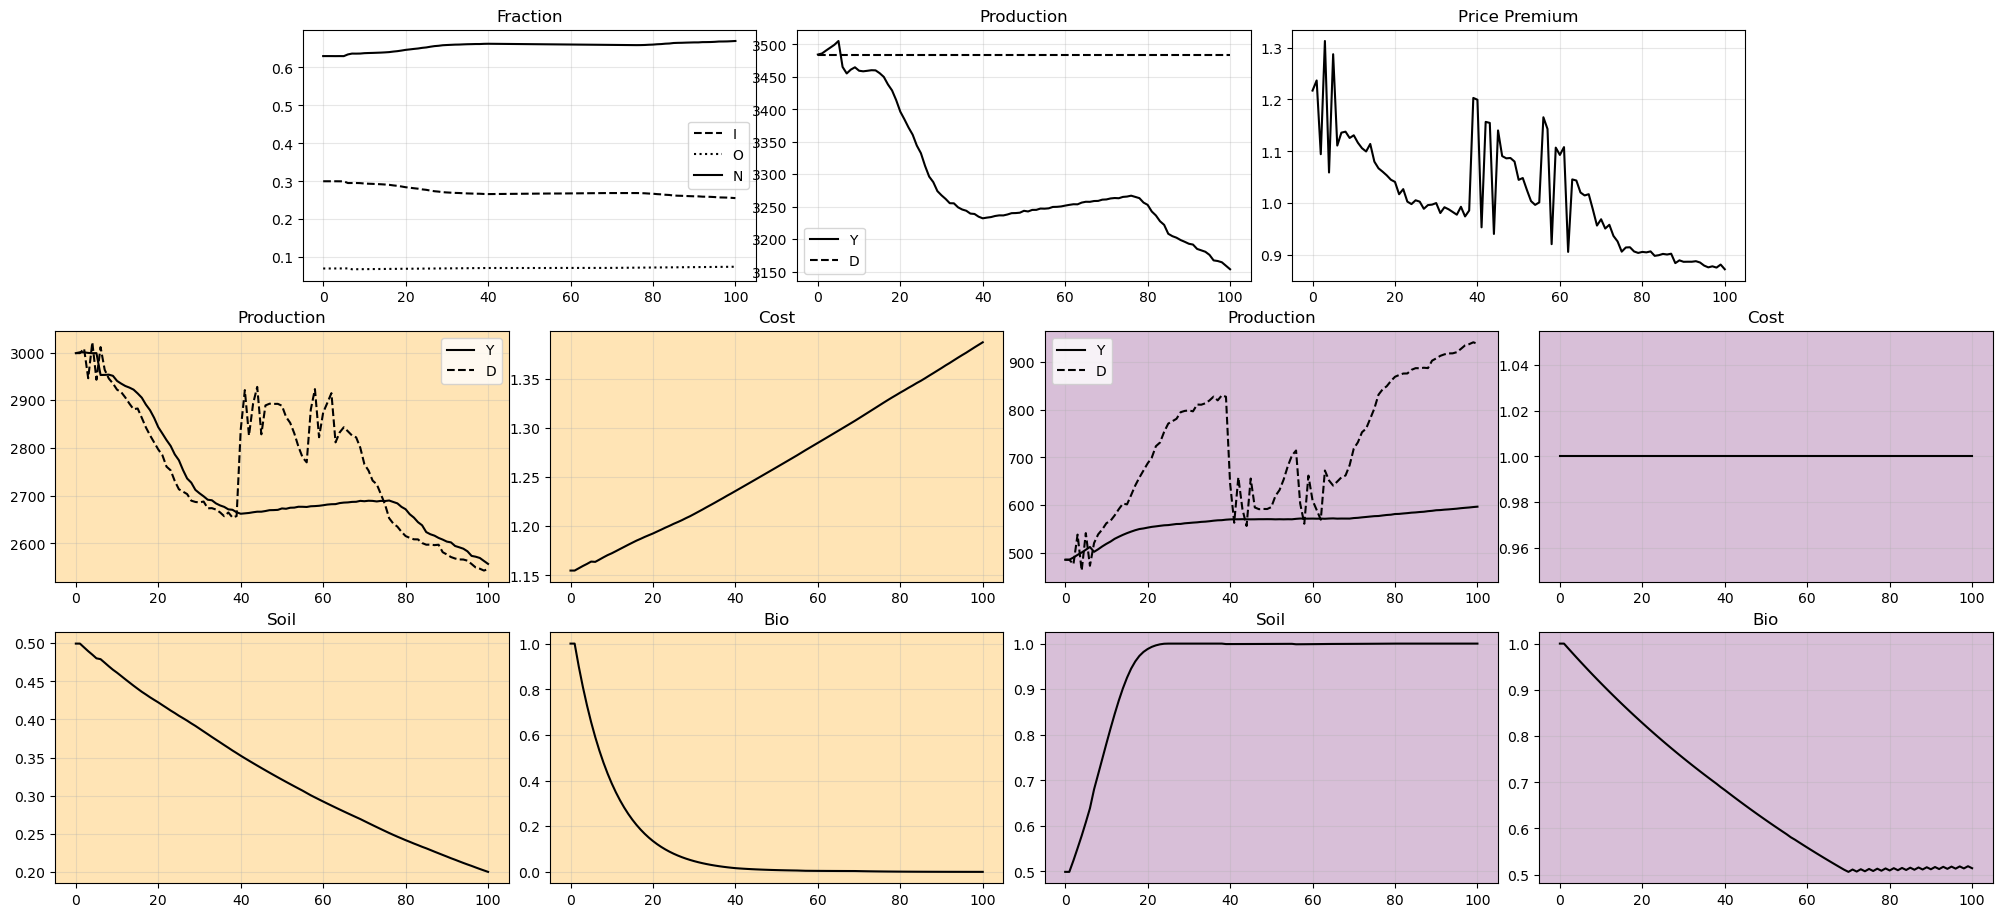

In [268]:

landscape = Landscape(size=100, frac_conventional=0.3, frac_organic=0.07,  
                        mean_soil_health_agri = 0.5, std_soil_health_agri = 0.1, mean_biodiversity_agri= 1, std_biodiversity_agri = 0, initial_wealth = 1, \
                            intensive_production = 1, intensive_costs = 1, soil_health_intensive_impact = -0.2, biodiversity_intensive_impact = 0., \
                                organic_production = 0.8, organic_costs = 1, soil_health_organic_impact = 0.2, biodiversity_organic_impact =0, \
                                    soil_health_natural_update = +0.001, soil_health_intensive_update = -0.01, soil_health_organic_update = 0.05, \
                                        biodiversity_natural_update = +0.01, biodiversity_intensive_update = -0.1, biodiversity_organic_update = 0.01, biodiversity_max_organic = 0.5, \
                                            cross_price_elasticity = 1)



for year in range(100):
    landscape.simulate_year()

landscape.plot_all_data()

In [261]:
landscape.data['I_wealth']

[1.0,
 1.1897860792210735,
 1.308277113092426,
 1.4102380202209275,
 1.4881208565975357,
 1.5399417833046567,
 1.6931978970442851,
 1.7613815200377831,
 1.8045551503910822,
 1.8790636534024119,
 1.997032797043275,
 2.1254232561963877,
 2.245168091785416,
 2.2995773283006713,
 2.4058225028826614,
 2.449477323397071,
 2.608869073744664,
 2.6760123723159364,
 2.749801242707052,
 2.802922791451307,
 2.9071382681206206,
 2.961471523719192,
 3.0814010346286116,
 3.0953994731344734,
 3.1555396138475755,
 3.2072060546326195,
 3.2347443772116216,
 3.3550448815216325,
 3.409984534343211,
 3.5026683489995736,
 3.5569807123797483,
 3.635521837174758,
 3.7266079452428285,
 3.8073959659789236,
 3.890565630827778,
 4.010926999467701,
 4.097076222433507,
 4.134173818009287,
 4.198067643035499,
 4.212219224481036,
 4.314894055474876,
 4.349973898935207,
 4.4224345310410085,
 4.470662573791878,
 4.558806302185786,
 4.67710416105046,
 4.786929298770742,
 4.84730759751641,
 4.944621076489199,
 5.010872895

In [227]:
np.array(landscape.data['O_demand'])/(np.array(landscape.data['O_demand']) + np.array(landscape.data['I_demand']))

array([0.44519599, 0.44519599, 0.44389473, ..., 0.38309739, 0.37498007,
       0.38914414])